In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 drehrsxe


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-drehrsxe:best, 314.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.7


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/5208 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/5208 [00:00<48:18,  1.80it/s]

  0%|▎                                                                                                                                                  | 9/5208 [00:00<04:54, 17.67it/s]

  0%|▌                                                                                                                                                 | 18/5208 [00:00<02:36, 33.18it/s]

  1%|▊                                                                                                                                                 | 27/5208 [00:00<01:52, 46.06it/s]

  1%|█                                                                                                                                                 | 36/5208 [00:00<01:31, 56.39it/s]

  1%|█▎                                                                                                                                                | 45/5208 [00:01<01:20, 64.17it/s]

  1%|█▌                                                                                                                                                | 54/5208 [00:01<01:13, 70.04it/s]

  1%|█▊                                                                                                                                                | 63/5208 [00:01<01:09, 74.31it/s]

  1%|██                                                                                                                                                | 72/5208 [00:01<01:06, 77.57it/s]

  2%|██▎                                                                                                                                               | 81/5208 [00:01<01:03, 80.22it/s]

  2%|██▌                                                                                                                                               | 90/5208 [00:01<01:02, 82.16it/s]

  2%|██▊                                                                                                                                               | 99/5208 [00:01<01:01, 83.09it/s]

  2%|███                                                                                                                                              | 108/5208 [00:01<01:00, 83.63it/s]

  2%|███▎                                                                                                                                             | 117/5208 [00:01<01:00, 84.03it/s]

  2%|███▌                                                                                                                                             | 126/5208 [00:02<01:00, 84.43it/s]

  3%|███▊                                                                                                                                             | 135/5208 [00:02<00:59, 84.55it/s]

  3%|████                                                                                                                                             | 144/5208 [00:02<00:59, 84.79it/s]

  3%|████▎                                                                                                                                            | 153/5208 [00:02<00:59, 85.02it/s]

  3%|████▌                                                                                                                                            | 162/5208 [00:02<00:59, 85.14it/s]

  3%|████▊                                                                                                                                            | 171/5208 [00:02<00:59, 85.14it/s]

  3%|█████                                                                                                                                            | 180/5208 [00:02<00:59, 85.20it/s]

  4%|█████▎                                                                                                                                           | 189/5208 [00:02<00:59, 85.03it/s]

  4%|█████▌                                                                                                                                           | 198/5208 [00:02<00:58, 85.53it/s]

  4%|█████▊                                                                                                                                           | 207/5208 [00:02<00:58, 85.39it/s]

  4%|██████                                                                                                                                           | 216/5208 [00:03<00:58, 85.33it/s]

  4%|██████▎                                                                                                                                          | 225/5208 [00:03<00:58, 85.67it/s]

  4%|██████▌                                                                                                                                          | 234/5208 [00:03<00:57, 85.82it/s]

  5%|██████▊                                                                                                                                          | 243/5208 [00:03<00:57, 85.87it/s]

  5%|███████                                                                                                                                          | 252/5208 [00:03<00:57, 85.92it/s]

  5%|███████▎                                                                                                                                         | 261/5208 [00:03<00:57, 86.64it/s]

  5%|███████▌                                                                                                                                         | 270/5208 [00:03<00:56, 87.35it/s]

  5%|███████▊                                                                                                                                         | 279/5208 [00:03<00:56, 87.30it/s]

  6%|████████                                                                                                                                         | 288/5208 [00:03<00:56, 86.75it/s]

  6%|████████▎                                                                                                                                        | 297/5208 [00:04<00:56, 86.47it/s]

  6%|████████▌                                                                                                                                        | 306/5208 [00:04<00:57, 85.94it/s]

  6%|████████▊                                                                                                                                        | 315/5208 [00:04<00:57, 85.78it/s]

  6%|█████████                                                                                                                                        | 324/5208 [00:04<00:56, 86.39it/s]

  6%|█████████▎                                                                                                                                       | 333/5208 [00:04<00:56, 86.33it/s]

  7%|█████████▌                                                                                                                                       | 342/5208 [00:04<00:56, 86.00it/s]

  7%|█████████▊                                                                                                                                       | 351/5208 [00:04<00:56, 85.68it/s]

  7%|██████████                                                                                                                                       | 360/5208 [00:04<00:56, 85.73it/s]

  7%|██████████▎                                                                                                                                      | 369/5208 [00:04<00:55, 86.52it/s]

  7%|██████████▌                                                                                                                                      | 378/5208 [00:04<00:55, 87.12it/s]

  7%|██████████▊                                                                                                                                      | 387/5208 [00:05<00:55, 87.53it/s]

  8%|███████████                                                                                                                                      | 396/5208 [00:05<00:55, 86.75it/s]

  8%|███████████▎                                                                                                                                     | 405/5208 [00:05<00:55, 86.61it/s]

  8%|███████████▌                                                                                                                                     | 414/5208 [00:05<00:55, 86.33it/s]

  8%|███████████▊                                                                                                                                     | 423/5208 [00:05<00:55, 85.95it/s]

  8%|████████████                                                                                                                                     | 432/5208 [00:05<00:55, 85.74it/s]

  8%|████████████▎                                                                                                                                    | 441/5208 [00:05<00:55, 85.44it/s]

  9%|████████████▌                                                                                                                                    | 450/5208 [00:05<00:55, 85.92it/s]

  9%|████████████▊                                                                                                                                    | 459/5208 [00:05<00:55, 85.79it/s]

  9%|█████████████                                                                                                                                    | 468/5208 [00:06<00:54, 86.50it/s]

  9%|█████████████▎                                                                                                                                   | 477/5208 [00:06<00:54, 87.22it/s]

  9%|█████████████▌                                                                                                                                   | 486/5208 [00:06<00:53, 87.55it/s]

 10%|█████████████▊                                                                                                                                   | 495/5208 [00:06<00:53, 87.46it/s]

 10%|██████████████                                                                                                                                   | 504/5208 [00:06<00:54, 87.00it/s]

 10%|██████████████▎                                                                                                                                  | 513/5208 [00:06<00:54, 86.54it/s]

 10%|██████████████▌                                                                                                                                  | 522/5208 [00:06<00:54, 86.01it/s]

 10%|██████████████▊                                                                                                                                  | 531/5208 [00:06<00:54, 86.16it/s]

 10%|███████████████                                                                                                                                  | 540/5208 [00:06<00:54, 85.82it/s]

 11%|███████████████▎                                                                                                                                 | 549/5208 [00:06<00:54, 85.75it/s]

 11%|███████████████▌                                                                                                                                 | 558/5208 [00:07<00:54, 85.53it/s]

 11%|███████████████▊                                                                                                                                 | 567/5208 [00:07<00:54, 85.44it/s]

 11%|████████████████                                                                                                                                 | 576/5208 [00:07<00:53, 85.99it/s]

 11%|████████████████▎                                                                                                                                | 585/5208 [00:07<00:53, 86.38it/s]

 11%|████████████████▌                                                                                                                                | 594/5208 [00:07<00:52, 87.17it/s]

 12%|████████████████▊                                                                                                                                | 603/5208 [00:07<00:52, 87.51it/s]

 12%|█████████████████                                                                                                                                | 612/5208 [00:07<00:52, 87.92it/s]

 12%|█████████████████▎                                                                                                                               | 621/5208 [00:07<00:52, 87.69it/s]

 12%|█████████████████▌                                                                                                                               | 630/5208 [00:07<00:52, 87.09it/s]

 12%|█████████████████▊                                                                                                                               | 639/5208 [00:07<00:52, 86.53it/s]

 12%|██████████████████                                                                                                                               | 648/5208 [00:08<00:52, 86.21it/s]

 13%|██████████████████▎                                                                                                                              | 657/5208 [00:08<00:52, 86.98it/s]

 13%|██████████████████▌                                                                                                                              | 666/5208 [00:08<00:52, 87.00it/s]

 13%|██████████████████▊                                                                                                                              | 675/5208 [00:08<00:52, 86.57it/s]

 13%|███████████████████                                                                                                                              | 684/5208 [00:08<00:52, 86.31it/s]

 13%|███████████████████▎                                                                                                                             | 693/5208 [00:08<00:52, 86.51it/s]

 13%|███████████████████▌                                                                                                                             | 702/5208 [00:08<00:52, 86.37it/s]

 14%|███████████████████▊                                                                                                                             | 711/5208 [00:08<00:51, 86.83it/s]

 14%|████████████████████                                                                                                                             | 720/5208 [00:08<00:51, 86.77it/s]

 14%|████████████████████▎                                                                                                                            | 729/5208 [00:09<00:51, 86.65it/s]

 14%|████████████████████▌                                                                                                                            | 738/5208 [00:09<00:51, 87.10it/s]

 14%|████████████████████▊                                                                                                                            | 747/5208 [00:09<00:51, 87.14it/s]

 15%|█████████████████████                                                                                                                            | 756/5208 [00:09<00:50, 87.80it/s]

 15%|█████████████████████▎                                                                                                                           | 765/5208 [00:09<00:50, 88.32it/s]

 15%|█████████████████████▌                                                                                                                           | 774/5208 [00:09<00:50, 88.65it/s]

 15%|█████████████████████▊                                                                                                                           | 783/5208 [00:09<00:49, 88.78it/s]

 15%|██████████████████████                                                                                                                           | 792/5208 [00:09<00:49, 89.00it/s]

 15%|██████████████████████▎                                                                                                                          | 801/5208 [00:09<00:49, 88.55it/s]

 16%|██████████████████████▌                                                                                                                          | 810/5208 [00:09<00:50, 87.95it/s]

 16%|██████████████████████▊                                                                                                                          | 819/5208 [00:10<00:50, 87.53it/s]

 16%|███████████████████████                                                                                                                          | 828/5208 [00:10<00:49, 87.75it/s]

 16%|███████████████████████▎                                                                                                                         | 837/5208 [00:10<00:49, 87.87it/s]

 16%|███████████████████████▌                                                                                                                         | 846/5208 [00:10<00:49, 87.70it/s]

 16%|███████████████████████▊                                                                                                                         | 855/5208 [00:10<00:49, 87.46it/s]

 17%|████████████████████████                                                                                                                         | 864/5208 [00:10<00:49, 87.19it/s]

 17%|████████████████████████▎                                                                                                                        | 873/5208 [00:10<00:49, 87.33it/s]

 17%|████████████████████████▌                                                                                                                        | 882/5208 [00:10<00:49, 87.21it/s]

 17%|████████████████████████▊                                                                                                                        | 891/5208 [00:10<00:49, 87.03it/s]

 17%|█████████████████████████                                                                                                                        | 900/5208 [00:10<00:49, 87.01it/s]

 17%|█████████████████████████▎                                                                                                                       | 909/5208 [00:11<00:49, 87.24it/s]

 18%|█████████████████████████▌                                                                                                                       | 918/5208 [00:11<00:49, 87.31it/s]

 18%|█████████████████████████▊                                                                                                                       | 927/5208 [00:11<00:49, 87.27it/s]

 18%|██████████████████████████                                                                                                                       | 936/5208 [00:11<00:48, 87.30it/s]

 18%|██████████████████████████▎                                                                                                                      | 945/5208 [00:11<00:48, 87.10it/s]

 18%|██████████████████████████▌                                                                                                                      | 954/5208 [00:11<00:48, 87.45it/s]

 18%|██████████████████████████▊                                                                                                                      | 963/5208 [00:11<00:48, 87.24it/s]

 19%|███████████████████████████                                                                                                                      | 972/5208 [00:11<00:48, 87.14it/s]

 19%|███████████████████████████▎                                                                                                                     | 981/5208 [00:11<00:48, 87.00it/s]

 19%|███████████████████████████▌                                                                                                                     | 990/5208 [00:11<00:48, 86.86it/s]

 19%|███████████████████████████▊                                                                                                                     | 999/5208 [00:12<00:48, 87.22it/s]

 19%|███████████████████████████▊                                                                                                                    | 1008/5208 [00:12<00:48, 87.20it/s]

 20%|████████████████████████████                                                                                                                    | 1017/5208 [00:12<00:48, 87.03it/s]

 20%|████████████████████████████▎                                                                                                                   | 1026/5208 [00:12<00:48, 86.99it/s]

 20%|████████████████████████████▌                                                                                                                   | 1035/5208 [00:12<00:47, 86.97it/s]

 20%|████████████████████████████▊                                                                                                                   | 1044/5208 [00:12<00:47, 87.21it/s]

 20%|█████████████████████████████                                                                                                                   | 1053/5208 [00:12<00:47, 87.09it/s]

 20%|█████████████████████████████▎                                                                                                                  | 1062/5208 [00:12<00:47, 87.02it/s]

 21%|█████████████████████████████▌                                                                                                                  | 1071/5208 [00:12<00:47, 86.89it/s]

 21%|█████████████████████████████▊                                                                                                                  | 1080/5208 [00:13<00:47, 87.07it/s]

 21%|██████████████████████████████                                                                                                                  | 1089/5208 [00:13<00:47, 87.21it/s]

 21%|██████████████████████████████▎                                                                                                                 | 1098/5208 [00:13<00:47, 86.98it/s]

 21%|██████████████████████████████▌                                                                                                                 | 1107/5208 [00:13<00:47, 86.98it/s]

 21%|██████████████████████████████▊                                                                                                                 | 1116/5208 [00:13<00:47, 86.87it/s]

 22%|███████████████████████████████                                                                                                                 | 1125/5208 [00:13<00:46, 87.27it/s]

 22%|███████████████████████████████▎                                                                                                                | 1134/5208 [00:13<00:46, 87.26it/s]

 22%|███████████████████████████████▌                                                                                                                | 1143/5208 [00:13<00:46, 87.14it/s]

 22%|███████████████████████████████▊                                                                                                                | 1152/5208 [00:13<00:46, 87.01it/s]

 22%|████████████████████████████████                                                                                                                | 1161/5208 [00:13<00:46, 86.94it/s]

 22%|████████████████████████████████▎                                                                                                               | 1170/5208 [00:14<00:46, 87.03it/s]

 23%|████████████████████████████████▌                                                                                                               | 1179/5208 [00:14<00:46, 86.36it/s]

 23%|████████████████████████████████▊                                                                                                               | 1188/5208 [00:14<00:46, 85.86it/s]

 23%|█████████████████████████████████                                                                                                               | 1197/5208 [00:14<00:47, 85.25it/s]

 23%|█████████████████████████████████▎                                                                                                              | 1206/5208 [00:14<00:47, 84.48it/s]

 23%|█████████████████████████████████▌                                                                                                              | 1215/5208 [00:14<00:47, 83.92it/s]

 24%|█████████████████████████████████▊                                                                                                              | 1224/5208 [00:14<00:47, 83.57it/s]

 24%|██████████████████████████████████                                                                                                              | 1233/5208 [00:14<00:47, 83.33it/s]

 24%|██████████████████████████████████▎                                                                                                             | 1242/5208 [00:14<00:47, 83.14it/s]

 24%|██████████████████████████████████▌                                                                                                             | 1251/5208 [00:15<00:47, 83.02it/s]

 24%|██████████████████████████████████▊                                                                                                             | 1260/5208 [00:15<00:47, 82.92it/s]

 24%|███████████████████████████████████                                                                                                             | 1269/5208 [00:15<00:47, 82.83it/s]

 25%|███████████████████████████████████▎                                                                                                            | 1278/5208 [00:15<00:47, 82.81it/s]

 25%|███████████████████████████████████▌                                                                                                            | 1287/5208 [00:15<00:47, 82.82it/s]

 25%|███████████████████████████████████▊                                                                                                            | 1296/5208 [00:15<00:47, 82.78it/s]

 25%|████████████████████████████████████                                                                                                            | 1305/5208 [00:15<00:47, 82.75it/s]

 25%|████████████████████████████████████▎                                                                                                           | 1314/5208 [00:15<00:47, 82.69it/s]

 25%|████████████████████████████████████▌                                                                                                           | 1323/5208 [00:15<00:46, 82.70it/s]

 26%|████████████████████████████████████▊                                                                                                           | 1332/5208 [00:16<00:46, 82.70it/s]

 26%|█████████████████████████████████████                                                                                                           | 1341/5208 [00:16<00:46, 82.70it/s]

 26%|█████████████████████████████████████▎                                                                                                          | 1350/5208 [00:16<00:46, 82.78it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 1359/5208 [00:16<00:46, 82.79it/s]

 26%|█████████████████████████████████████▊                                                                                                          | 1368/5208 [00:16<00:46, 82.77it/s]

 26%|██████████████████████████████████████                                                                                                          | 1377/5208 [00:16<00:46, 82.76it/s]

 27%|██████████████████████████████████████▎                                                                                                         | 1386/5208 [00:16<00:46, 82.79it/s]

 27%|██████████████████████████████████████▌                                                                                                         | 1395/5208 [00:16<00:46, 82.75it/s]

 27%|██████████████████████████████████████▊                                                                                                         | 1404/5208 [00:16<00:46, 82.69it/s]

 27%|███████████████████████████████████████                                                                                                         | 1413/5208 [00:16<00:45, 82.70it/s]

 27%|███████████████████████████████████████▎                                                                                                        | 1422/5208 [00:17<00:45, 82.68it/s]

 27%|███████████████████████████████████████▌                                                                                                        | 1431/5208 [00:17<00:45, 82.72it/s]

 28%|███████████████████████████████████████▊                                                                                                        | 1440/5208 [00:17<00:45, 82.72it/s]

 28%|████████████████████████████████████████                                                                                                        | 1449/5208 [00:17<00:45, 82.74it/s]

 28%|████████████████████████████████████████▎                                                                                                       | 1458/5208 [00:17<00:45, 82.78it/s]

 28%|████████████████████████████████████████▌                                                                                                       | 1467/5208 [00:17<00:45, 82.74it/s]

 28%|████████████████████████████████████████▊                                                                                                       | 1476/5208 [00:17<00:45, 82.74it/s]

 29%|█████████████████████████████████████████                                                                                                       | 1485/5208 [00:17<00:45, 82.59it/s]

 29%|█████████████████████████████████████████▎                                                                                                      | 1494/5208 [00:17<00:44, 82.62it/s]

 29%|█████████████████████████████████████████▌                                                                                                      | 1503/5208 [00:18<00:44, 82.66it/s]

 29%|█████████████████████████████████████████▊                                                                                                      | 1512/5208 [00:18<00:44, 82.69it/s]

 29%|██████████████████████████████████████████                                                                                                      | 1521/5208 [00:18<00:44, 82.68it/s]

 29%|██████████████████████████████████████████▎                                                                                                     | 1530/5208 [00:18<00:44, 82.66it/s]

 30%|██████████████████████████████████████████▌                                                                                                     | 1539/5208 [00:18<00:44, 82.64it/s]

 30%|██████████████████████████████████████████▊                                                                                                     | 1548/5208 [00:18<00:44, 82.93it/s]

 30%|███████████████████████████████████████████                                                                                                     | 1557/5208 [00:18<00:43, 83.50it/s]

 30%|███████████████████████████████████████████▎                                                                                                    | 1566/5208 [00:18<00:43, 83.90it/s]

 30%|███████████████████████████████████████████▌                                                                                                    | 1575/5208 [00:18<00:43, 84.18it/s]

 30%|███████████████████████████████████████████▊                                                                                                    | 1584/5208 [00:19<00:42, 84.36it/s]

 31%|████████████████████████████████████████████                                                                                                    | 1593/5208 [00:19<00:42, 84.49it/s]

 31%|████████████████████████████████████████████▎                                                                                                   | 1602/5208 [00:19<00:42, 84.59it/s]

 31%|████████████████████████████████████████████▌                                                                                                   | 1611/5208 [00:19<00:42, 84.66it/s]

 31%|████████████████████████████████████████████▊                                                                                                   | 1620/5208 [00:19<00:42, 84.72it/s]

 31%|█████████████████████████████████████████████                                                                                                   | 1629/5208 [00:19<00:42, 84.74it/s]

 31%|█████████████████████████████████████████████▎                                                                                                  | 1638/5208 [00:19<00:42, 84.76it/s]

 32%|█████████████████████████████████████████████▌                                                                                                  | 1647/5208 [00:19<00:42, 84.76it/s]

 32%|█████████████████████████████████████████████▊                                                                                                  | 1656/5208 [00:19<00:41, 84.75it/s]

 32%|██████████████████████████████████████████████                                                                                                  | 1665/5208 [00:20<00:41, 84.65it/s]

 32%|██████████████████████████████████████████████▎                                                                                                 | 1674/5208 [00:20<00:41, 84.71it/s]

 32%|██████████████████████████████████████████████▌                                                                                                 | 1683/5208 [00:20<00:41, 84.59it/s]

 32%|██████████████████████████████████████████████▊                                                                                                 | 1692/5208 [00:20<00:41, 84.46it/s]

 33%|███████████████████████████████████████████████                                                                                                 | 1701/5208 [00:20<00:41, 84.23it/s]

 33%|███████████████████████████████████████████████▎                                                                                                | 1710/5208 [00:20<00:41, 84.38it/s]

 33%|███████████████████████████████████████████████▌                                                                                                | 1719/5208 [00:20<00:41, 84.47it/s]

 33%|███████████████████████████████████████████████▊                                                                                                | 1728/5208 [00:20<00:41, 84.54it/s]

 33%|████████████████████████████████████████████████                                                                                                | 1737/5208 [00:20<00:41, 84.58it/s]

 34%|████████████████████████████████████████████████▎                                                                                               | 1746/5208 [00:20<00:40, 84.62it/s]

 34%|████████████████████████████████████████████████▌                                                                                               | 1755/5208 [00:21<00:40, 84.62it/s]

 34%|████████████████████████████████████████████████▊                                                                                               | 1764/5208 [00:21<00:40, 84.70it/s]

 34%|█████████████████████████████████████████████████                                                                                               | 1773/5208 [00:21<00:40, 84.78it/s]

 34%|█████████████████████████████████████████████████▎                                                                                              | 1782/5208 [00:21<00:40, 84.99it/s]

 34%|█████████████████████████████████████████████████▌                                                                                              | 1791/5208 [00:21<00:40, 85.08it/s]

 35%|█████████████████████████████████████████████████▊                                                                                              | 1800/5208 [00:21<00:40, 85.19it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 1809/5208 [00:21<00:39, 85.18it/s]

 35%|██████████████████████████████████████████████████▎                                                                                             | 1818/5208 [00:21<00:39, 85.20it/s]

 35%|██████████████████████████████████████████████████▌                                                                                             | 1827/5208 [00:21<00:39, 85.21it/s]

 35%|██████████████████████████████████████████████████▊                                                                                             | 1836/5208 [00:22<00:39, 85.24it/s]

 35%|███████████████████████████████████████████████████                                                                                             | 1845/5208 [00:22<00:39, 85.26it/s]

 36%|███████████████████████████████████████████████████▎                                                                                            | 1854/5208 [00:22<00:39, 85.28it/s]

 36%|███████████████████████████████████████████████████▌                                                                                            | 1863/5208 [00:22<00:39, 85.35it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 1872/5208 [00:22<00:39, 85.15it/s]

 36%|████████████████████████████████████████████████████                                                                                            | 1881/5208 [00:22<00:39, 85.21it/s]

 36%|████████████████████████████████████████████████████▎                                                                                           | 1890/5208 [00:22<00:38, 85.25it/s]

 36%|████████████████████████████████████████████████████▌                                                                                           | 1899/5208 [00:22<00:38, 85.23it/s]

 37%|████████████████████████████████████████████████████▊                                                                                           | 1908/5208 [00:22<00:38, 85.28it/s]

 37%|█████████████████████████████████████████████████████                                                                                           | 1917/5208 [00:22<00:38, 85.27it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 1926/5208 [00:23<00:38, 85.24it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                          | 1935/5208 [00:23<00:38, 85.20it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                          | 1944/5208 [00:23<00:38, 85.26it/s]

 38%|██████████████████████████████████████████████████████                                                                                          | 1953/5208 [00:23<00:38, 85.30it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                         | 1962/5208 [00:23<00:38, 85.28it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                         | 1971/5208 [00:23<00:37, 85.35it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 1980/5208 [00:23<00:37, 85.26it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                         | 1989/5208 [00:23<00:37, 85.29it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                        | 1998/5208 [00:23<00:37, 85.29it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                        | 2007/5208 [00:24<00:37, 85.32it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 2016/5208 [00:24<00:37, 85.32it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 2025/5208 [00:24<00:37, 84.89it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 2034/5208 [00:24<00:37, 84.94it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 2043/5208 [00:24<00:37, 85.02it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 2052/5208 [00:24<00:37, 85.06it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 2061/5208 [00:24<00:36, 85.11it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 2070/5208 [00:24<00:36, 85.20it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                      | 2079/5208 [00:24<00:36, 85.18it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                      | 2088/5208 [00:24<00:36, 85.20it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                      | 2097/5208 [00:25<00:36, 85.18it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 2106/5208 [00:25<00:36, 85.07it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 2115/5208 [00:25<00:36, 85.12it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 2124/5208 [00:25<00:36, 85.12it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 2133/5208 [00:25<00:36, 85.11it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 2142/5208 [00:25<00:36, 85.10it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 2151/5208 [00:25<00:35, 85.13it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 2160/5208 [00:25<00:35, 85.12it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 2169/5208 [00:25<00:35, 85.16it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 2178/5208 [00:26<00:35, 85.22it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 2187/5208 [00:26<00:35, 85.19it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                   | 2196/5208 [00:26<00:35, 85.22it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 2205/5208 [00:26<00:35, 85.23it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                                  | 2214/5208 [00:26<00:35, 85.25it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 2223/5208 [00:26<00:35, 85.20it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 2232/5208 [00:26<00:34, 85.23it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 2241/5208 [00:26<00:34, 85.18it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 2250/5208 [00:26<00:34, 85.17it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 2259/5208 [00:26<00:34, 85.18it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                                 | 2268/5208 [00:27<00:34, 85.17it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                 | 2277/5208 [00:27<00:34, 85.17it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                | 2286/5208 [00:27<00:34, 85.20it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                | 2295/5208 [00:27<00:34, 85.22it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 2304/5208 [00:27<00:34, 84.62it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                | 2313/5208 [00:27<00:34, 84.02it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 2322/5208 [00:27<00:34, 83.59it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 2331/5208 [00:27<00:34, 83.31it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                               | 2340/5208 [00:27<00:34, 83.13it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                               | 2349/5208 [00:28<00:34, 83.02it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                              | 2358/5208 [00:28<00:34, 82.93it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 2367/5208 [00:28<00:34, 82.86it/s]

 46%|█████████████████████████████████████████████████████████████████▋                                                                              | 2376/5208 [00:28<00:34, 82.70it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                              | 2385/5208 [00:28<00:34, 82.73it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 2394/5208 [00:28<00:34, 82.72it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                             | 2403/5208 [00:28<00:33, 82.74it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 2412/5208 [00:28<00:33, 82.74it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                             | 2421/5208 [00:28<00:33, 82.75it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 2430/5208 [00:29<00:33, 82.76it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 2439/5208 [00:29<00:33, 82.75it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 2448/5208 [00:29<00:33, 82.73it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 2457/5208 [00:29<00:33, 82.72it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 2466/5208 [00:29<00:33, 82.75it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                           | 2475/5208 [00:29<00:33, 82.76it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 2484/5208 [00:29<00:32, 82.73it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                           | 2493/5208 [00:29<00:32, 82.75it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 2502/5208 [00:29<00:32, 82.77it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 2511/5208 [00:30<00:32, 82.73it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 2520/5208 [00:30<00:32, 82.77it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 2529/5208 [00:30<00:32, 82.77it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 2538/5208 [00:30<00:32, 82.66it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 2547/5208 [00:30<00:32, 82.72it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 2556/5208 [00:30<00:32, 82.72it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                         | 2565/5208 [00:30<00:31, 82.76it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 2574/5208 [00:30<00:31, 82.76it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 2583/5208 [00:30<00:31, 82.76it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 2592/5208 [00:31<00:31, 82.78it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 2601/5208 [00:31<00:31, 82.82it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 2610/5208 [00:31<00:31, 82.81it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 2619/5208 [00:31<00:31, 82.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                       | 2628/5208 [00:31<00:31, 82.83it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 2637/5208 [00:31<00:31, 82.68it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 2646/5208 [00:31<00:30, 82.71it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 2655/5208 [00:31<00:30, 82.74it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                      | 2664/5208 [00:31<00:30, 82.79it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 2673/5208 [00:31<00:30, 82.64it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 2682/5208 [00:32<00:30, 82.67it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 2691/5208 [00:32<00:30, 82.62it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 2700/5208 [00:32<00:30, 82.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 2709/5208 [00:32<00:30, 82.56it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 2718/5208 [00:32<00:30, 82.66it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 2727/5208 [00:32<00:30, 82.68it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 2736/5208 [00:32<00:29, 82.77it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 2745/5208 [00:32<00:29, 82.57it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 2754/5208 [00:32<00:29, 82.59it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 2763/5208 [00:33<00:29, 82.67it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                   | 2772/5208 [00:33<00:29, 82.72it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 2781/5208 [00:33<00:29, 82.72it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 2790/5208 [00:33<00:29, 82.80it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 2799/5208 [00:33<00:29, 82.81it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 2808/5208 [00:33<00:28, 82.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 2817/5208 [00:33<00:28, 82.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 2826/5208 [00:33<00:28, 82.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 2835/5208 [00:33<00:28, 82.79it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 2844/5208 [00:34<00:28, 82.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 2853/5208 [00:34<00:28, 82.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 2862/5208 [00:34<00:28, 82.85it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 2871/5208 [00:34<00:28, 82.80it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 2880/5208 [00:34<00:28, 82.78it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 2889/5208 [00:34<00:28, 82.81it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 2898/5208 [00:34<00:27, 82.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 2907/5208 [00:34<00:27, 82.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 2916/5208 [00:34<00:27, 82.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 2925/5208 [00:35<00:27, 82.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 2934/5208 [00:35<00:27, 82.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 2943/5208 [00:35<00:27, 82.79it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 2952/5208 [00:35<00:27, 82.81it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 2961/5208 [00:35<00:27, 82.79it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 2970/5208 [00:35<00:27, 82.51it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 2979/5208 [00:35<00:27, 82.09it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 2988/5208 [00:35<00:27, 81.75it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 2997/5208 [00:35<00:27, 81.48it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 3006/5208 [00:36<00:27, 81.08it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 3015/5208 [00:36<00:27, 81.04it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 3024/5208 [00:36<00:26, 81.02it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 3033/5208 [00:36<00:26, 80.98it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 3042/5208 [00:36<00:26, 80.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3051/5208 [00:36<00:26, 80.90it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3060/5208 [00:36<00:26, 80.91it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3069/5208 [00:36<00:26, 80.93it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 3078/5208 [00:36<00:26, 80.94it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 3087/5208 [00:37<00:26, 80.96it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3096/5208 [00:37<00:26, 80.96it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3105/5208 [00:37<00:25, 80.98it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 3114/5208 [00:37<00:25, 80.96it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3123/5208 [00:37<00:25, 80.97it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3132/5208 [00:37<00:25, 80.94it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3141/5208 [00:37<00:25, 80.77it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 3150/5208 [00:37<00:25, 80.84it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3159/5208 [00:37<00:25, 80.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3168/5208 [00:38<00:25, 81.03it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3177/5208 [00:38<00:25, 81.04it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 3186/5208 [00:38<00:24, 81.04it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3195/5208 [00:38<00:24, 81.05it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3204/5208 [00:38<00:24, 81.05it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3213/5208 [00:38<00:24, 81.10it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 3222/5208 [00:38<00:24, 81.07it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3231/5208 [00:38<00:24, 81.03it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3240/5208 [00:38<00:24, 81.03it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3249/5208 [00:39<00:24, 81.05it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 3258/5208 [00:39<00:24, 81.02it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3267/5208 [00:39<00:23, 81.04it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3276/5208 [00:39<00:23, 80.99it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3285/5208 [00:39<00:23, 81.03it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 3294/5208 [00:39<00:23, 80.97it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3303/5208 [00:39<00:23, 80.99it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3312/5208 [00:39<00:23, 80.96it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3321/5208 [00:39<00:23, 81.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3330/5208 [00:40<00:23, 81.03it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3339/5208 [00:40<00:23, 81.05it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3348/5208 [00:40<00:22, 81.03it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3357/5208 [00:40<00:22, 81.00it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3366/5208 [00:40<00:22, 81.02it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3375/5208 [00:40<00:22, 80.98it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3384/5208 [00:40<00:22, 80.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3393/5208 [00:40<00:22, 80.81it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3402/5208 [00:40<00:22, 80.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3411/5208 [00:41<00:22, 80.90it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3420/5208 [00:41<00:22, 80.91it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3429/5208 [00:41<00:21, 80.90it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3438/5208 [00:41<00:21, 80.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3447/5208 [00:41<00:21, 80.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3456/5208 [00:41<00:21, 80.98it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3465/5208 [00:41<00:21, 80.98it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3474/5208 [00:41<00:21, 80.99it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3483/5208 [00:41<00:21, 80.96it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3492/5208 [00:42<00:21, 80.99it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3501/5208 [00:42<00:21, 80.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3510/5208 [00:42<00:20, 80.98it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3519/5208 [00:42<00:20, 80.97it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3528/5208 [00:42<00:20, 80.98it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3537/5208 [00:42<00:20, 80.97it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3546/5208 [00:42<00:20, 80.98it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3555/5208 [00:42<00:20, 81.00it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3564/5208 [00:42<00:20, 81.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3573/5208 [00:43<00:20, 80.97it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3582/5208 [00:43<00:20, 80.97it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3591/5208 [00:43<00:19, 80.94it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3600/5208 [00:43<00:19, 80.95it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3609/5208 [00:43<00:19, 80.96it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3618/5208 [00:43<00:19, 81.46it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3627/5208 [00:43<00:19, 81.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3636/5208 [00:43<00:19, 82.09it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3645/5208 [00:43<00:18, 82.29it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3654/5208 [00:44<00:18, 82.39it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3663/5208 [00:44<00:18, 82.53it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3672/5208 [00:44<00:18, 82.61it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3681/5208 [00:44<00:18, 82.64it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3690/5208 [00:44<00:18, 82.65it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3699/5208 [00:44<00:18, 82.70it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3708/5208 [00:44<00:18, 82.66it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3717/5208 [00:44<00:18, 82.61it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3726/5208 [00:44<00:17, 82.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3735/5208 [00:44<00:17, 82.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3744/5208 [00:45<00:17, 82.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3753/5208 [00:45<00:17, 82.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3762/5208 [00:45<00:17, 82.56it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3771/5208 [00:45<00:17, 82.63it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3780/5208 [00:45<00:17, 82.70it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3789/5208 [00:45<00:17, 82.65it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3798/5208 [00:45<00:17, 82.64it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3807/5208 [00:45<00:16, 82.43it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3816/5208 [00:45<00:16, 82.50it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3825/5208 [00:46<00:16, 82.52it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3834/5208 [00:46<00:16, 82.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3843/5208 [00:46<00:16, 82.62it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3852/5208 [00:46<00:16, 82.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3861/5208 [00:46<00:16, 82.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3870/5208 [00:46<00:16, 82.64it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3879/5208 [00:46<00:16, 82.68it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3888/5208 [00:46<00:15, 82.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3897/5208 [00:46<00:15, 82.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3906/5208 [00:47<00:15, 82.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3915/5208 [00:47<00:15, 82.68it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3924/5208 [00:47<00:15, 82.64it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3933/5208 [00:47<00:15, 82.61it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3942/5208 [00:47<00:15, 82.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3951/5208 [00:47<00:15, 82.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3960/5208 [00:47<00:15, 82.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3969/5208 [00:47<00:14, 82.70it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3978/5208 [00:47<00:14, 82.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3987/5208 [00:48<00:14, 82.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3996/5208 [00:48<00:14, 82.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4005/5208 [00:48<00:14, 82.67it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4014/5208 [00:48<00:14, 82.71it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4023/5208 [00:48<00:14, 82.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4032/5208 [00:48<00:14, 82.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4041/5208 [00:48<00:14, 82.59it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4050/5208 [00:48<00:14, 82.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4059/5208 [00:48<00:13, 82.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4068/5208 [00:49<00:13, 82.63it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4077/5208 [00:49<00:13, 82.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4086/5208 [00:49<00:13, 82.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4095/5208 [00:49<00:13, 82.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4104/5208 [00:49<00:13, 82.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4113/5208 [00:49<00:13, 82.67it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4122/5208 [00:49<00:13, 82.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4131/5208 [00:49<00:13, 82.46it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4140/5208 [00:49<00:12, 82.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4149/5208 [00:49<00:12, 82.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4158/5208 [00:50<00:12, 82.61it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4167/5208 [00:50<00:12, 82.68it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4176/5208 [00:50<00:12, 82.59it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4185/5208 [00:50<00:12, 82.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4194/5208 [00:50<00:12, 82.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4203/5208 [00:50<00:12, 82.69it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4212/5208 [00:50<00:12, 82.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4221/5208 [00:50<00:11, 82.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4230/5208 [00:50<00:11, 82.66it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4239/5208 [00:51<00:11, 82.63it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4248/5208 [00:51<00:11, 82.61it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4257/5208 [00:51<00:11, 82.64it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4266/5208 [00:51<00:11, 82.62it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4275/5208 [00:51<00:11, 82.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4284/5208 [00:51<00:11, 82.42it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4293/5208 [00:51<00:11, 82.47it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4302/5208 [00:51<00:10, 82.50it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4311/5208 [00:51<00:10, 82.44it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4320/5208 [00:52<00:10, 82.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4329/5208 [00:52<00:10, 82.41it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4338/5208 [00:52<00:10, 82.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4347/5208 [00:52<00:10, 82.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4356/5208 [00:52<00:10, 82.40it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4365/5208 [00:52<00:10, 82.40it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4374/5208 [00:52<00:10, 82.41it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4383/5208 [00:52<00:10, 82.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4392/5208 [00:52<00:09, 82.44it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4401/5208 [00:53<00:09, 82.33it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 4410/5208 [00:53<00:09, 82.41it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4419/5208 [00:53<00:09, 82.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4428/5208 [00:53<00:09, 82.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4437/5208 [00:53<00:09, 82.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4446/5208 [00:53<00:09, 82.41it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4455/5208 [00:53<00:09, 82.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4464/5208 [00:53<00:09, 82.58it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4473/5208 [00:53<00:08, 82.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4482/5208 [00:54<00:08, 82.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4491/5208 [00:54<00:08, 82.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4500/5208 [00:54<00:08, 82.43it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4509/5208 [00:54<00:08, 82.29it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4518/5208 [00:54<00:08, 82.31it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4527/5208 [00:54<00:08, 82.33it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4536/5208 [00:54<00:08, 82.32it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4545/5208 [00:54<00:08, 82.33it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4554/5208 [00:54<00:07, 82.38it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4563/5208 [00:55<00:07, 82.36it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4572/5208 [00:55<00:07, 82.41it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4581/5208 [00:55<00:07, 82.40it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4590/5208 [00:55<00:07, 82.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4599/5208 [00:55<00:07, 82.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4608/5208 [00:55<00:07, 82.41it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4617/5208 [00:55<00:07, 82.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4626/5208 [00:55<00:07, 82.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4635/5208 [00:55<00:06, 82.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4644/5208 [00:56<00:06, 82.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4653/5208 [00:56<00:06, 82.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4662/5208 [00:56<00:06, 82.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4671/5208 [00:56<00:06, 82.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4680/5208 [00:56<00:06, 81.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4689/5208 [00:56<00:06, 81.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4698/5208 [00:56<00:06, 81.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4707/5208 [00:56<00:06, 81.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4716/5208 [00:56<00:05, 82.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4725/5208 [00:56<00:05, 82.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4734/5208 [00:57<00:05, 82.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4743/5208 [00:57<00:05, 82.05it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4752/5208 [00:57<00:05, 82.00it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4761/5208 [00:57<00:05, 82.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4770/5208 [00:57<00:05, 81.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4779/5208 [00:57<00:05, 81.92it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4788/5208 [00:57<00:05, 81.93it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4797/5208 [00:57<00:05, 82.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4806/5208 [00:57<00:04, 82.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4815/5208 [00:58<00:04, 81.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4824/5208 [00:58<00:04, 81.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4833/5208 [00:58<00:04, 82.11it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4842/5208 [00:58<00:04, 82.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4851/5208 [00:58<00:04, 82.33it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4860/5208 [00:58<00:04, 82.36it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4869/5208 [00:58<00:04, 82.47it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4878/5208 [00:58<00:04, 82.39it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4887/5208 [00:58<00:03, 82.46it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4896/5208 [00:59<00:03, 82.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4905/5208 [00:59<00:03, 82.46it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4914/5208 [00:59<00:03, 82.62it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4923/5208 [00:59<00:03, 82.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4932/5208 [00:59<00:03, 82.44it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4941/5208 [00:59<00:03, 82.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4950/5208 [00:59<00:03, 82.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4959/5208 [00:59<00:03, 82.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4968/5208 [00:59<00:02, 82.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4977/5208 [01:00<00:02, 82.16it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4986/5208 [01:00<00:02, 82.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4995/5208 [01:00<00:02, 82.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5004/5208 [01:00<00:02, 82.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5013/5208 [01:00<00:02, 82.30it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5022/5208 [01:00<00:02, 82.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5031/5208 [01:00<00:02, 82.27it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5040/5208 [01:00<00:02, 82.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5049/5208 [01:00<00:01, 82.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5058/5208 [01:01<00:01, 82.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5067/5208 [01:01<00:01, 82.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5076/5208 [01:01<00:01, 82.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5085/5208 [01:01<00:01, 82.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5094/5208 [01:01<00:01, 82.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5103/5208 [01:01<00:01, 82.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5112/5208 [01:01<00:01, 82.44it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5121/5208 [01:01<00:01, 82.49it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5130/5208 [01:01<00:00, 82.41it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5139/5208 [01:02<00:00, 82.41it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5148/5208 [01:02<00:00, 82.43it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5157/5208 [01:02<00:00, 82.33it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5166/5208 [01:02<00:00, 82.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5175/5208 [01:02<00:00, 82.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5184/5208 [01:02<00:00, 82.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5193/5208 [01:02<00:00, 82.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5202/5208 [01:02<00:00, 79.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [01:02<00:00, 82.76it/s]

train - OK


  0%|                                                                                                                                                            | 0/677 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                   | 1/677 [00:00<05:44,  1.96it/s]

  1%|█▉                                                                                                                                                  | 9/677 [00:00<00:35, 19.00it/s]

  3%|███▉                                                                                                                                               | 18/677 [00:00<00:18, 35.08it/s]

  4%|█████▊                                                                                                                                             | 27/677 [00:00<00:13, 47.46it/s]

  5%|███████▊                                                                                                                                           | 36/677 [00:00<00:11, 57.03it/s]

  7%|█████████▊                                                                                                                                         | 45/677 [00:01<00:09, 63.91it/s]

  8%|███████████▋                                                                                                                                       | 54/677 [00:01<00:09, 69.20it/s]

  9%|█████████████▋                                                                                                                                     | 63/677 [00:01<00:08, 73.00it/s]

 11%|███████████████▋                                                                                                                                   | 72/677 [00:01<00:08, 75.30it/s]

 12%|█████████████████▌                                                                                                                                 | 81/677 [00:01<00:07, 77.37it/s]

 13%|███████████████████▌                                                                                                                               | 90/677 [00:01<00:07, 78.52it/s]

 15%|█████████████████████▍                                                                                                                             | 99/677 [00:01<00:07, 79.52it/s]

 16%|███████████████████████▎                                                                                                                          | 108/677 [00:01<00:07, 80.31it/s]

 17%|█████████████████████████▏                                                                                                                        | 117/677 [00:01<00:06, 80.51it/s]

 19%|███████████████████████████▏                                                                                                                      | 126/677 [00:02<00:06, 81.03it/s]

 20%|█████████████████████████████                                                                                                                     | 135/677 [00:02<00:06, 81.19it/s]

 21%|███████████████████████████████                                                                                                                   | 144/677 [00:02<00:06, 81.27it/s]

 23%|████████████████████████████████▉                                                                                                                 | 153/677 [00:02<00:06, 81.60it/s]

 24%|██████████████████████████████████▉                                                                                                               | 162/677 [00:02<00:06, 81.38it/s]

 25%|████████████████████████████████████▉                                                                                                             | 171/677 [00:02<00:06, 81.66it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 180/677 [00:02<00:06, 81.70it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 189/677 [00:02<00:05, 81.54it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 198/677 [00:02<00:05, 81.72it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 207/677 [00:03<00:05, 81.49it/s]

 32%|██████████████████████████████████████████████▌                                                                                                   | 216/677 [00:03<00:05, 81.72it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 225/677 [00:03<00:05, 81.78it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 234/677 [00:03<00:05, 81.51it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 243/677 [00:03<00:05, 81.74it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 252/677 [00:03<00:05, 81.56it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                         | 261/677 [00:03<00:05, 81.79it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 270/677 [00:03<00:04, 81.94it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 279/677 [00:03<00:04, 81.66it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                    | 288/677 [00:04<00:04, 81.91it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                  | 297/677 [00:04<00:04, 81.68it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 306/677 [00:04<00:04, 81.82it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                              | 315/677 [00:04<00:04, 82.02it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 324/677 [00:04<00:04, 81.68it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 333/677 [00:04<00:04, 81.41it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 342/677 [00:04<00:04, 81.73it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 351/677 [00:04<00:03, 81.64it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                    | 360/677 [00:04<00:03, 81.39it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 369/677 [00:05<00:03, 81.56it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 378/677 [00:05<00:03, 81.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 387/677 [00:05<00:03, 81.56it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 396/677 [00:05<00:03, 81.80it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 405/677 [00:05<00:03, 81.76it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 414/677 [00:05<00:03, 81.76it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 423/677 [00:05<00:03, 81.71it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 432/677 [00:05<00:02, 81.68it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 441/677 [00:05<00:02, 81.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 450/677 [00:06<00:02, 81.62it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 459/677 [00:06<00:02, 81.44it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 468/677 [00:06<00:02, 81.29it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 477/677 [00:06<00:02, 81.62it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 486/677 [00:06<00:02, 81.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 495/677 [00:06<00:02, 81.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 504/677 [00:06<00:02, 81.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 513/677 [00:06<00:02, 81.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 522/677 [00:06<00:01, 81.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 531/677 [00:06<00:01, 82.00it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 540/677 [00:07<00:01, 81.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 549/677 [00:07<00:01, 81.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 558/677 [00:07<00:01, 82.02it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 567/677 [00:07<00:01, 81.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 576/677 [00:07<00:01, 81.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 585/677 [00:07<00:01, 82.04it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 594/677 [00:07<00:01, 82.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 603/677 [00:07<00:00, 81.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 612/677 [00:07<00:00, 81.94it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 621/677 [00:08<00:00, 82.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 630/677 [00:08<00:00, 81.69it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 639/677 [00:08<00:00, 81.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 648/677 [00:08<00:00, 81.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 657/677 [00:08<00:00, 81.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 666/677 [00:08<00:00, 83.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 675/677 [00:08<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:09<00:00, 74.98it/s]

val - OK


  0%|                                                                                                                                                            | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                   | 1/680 [00:00<06:14,  1.81it/s]

  1%|██▏                                                                                                                                                | 10/680 [00:00<00:33, 19.76it/s]

  3%|████                                                                                                                                               | 19/680 [00:00<00:18, 35.32it/s]

  4%|██████                                                                                                                                             | 28/680 [00:00<00:13, 47.95it/s]

  5%|███████▉                                                                                                                                           | 37/680 [00:00<00:11, 58.13it/s]

  7%|█████████▉                                                                                                                                         | 46/680 [00:01<00:09, 65.84it/s]

  8%|███████████▉                                                                                                                                       | 55/680 [00:01<00:08, 71.57it/s]

  9%|█████████████▊                                                                                                                                     | 64/680 [00:01<00:08, 75.93it/s]

 11%|███████████████▊                                                                                                                                   | 73/680 [00:01<00:07, 78.65it/s]

 12%|█████████████████▋                                                                                                                                 | 82/680 [00:01<00:07, 81.09it/s]

 13%|███████████████████▋                                                                                                                               | 91/680 [00:01<00:07, 82.73it/s]

 15%|█████████████████████▍                                                                                                                            | 100/680 [00:01<00:06, 83.68it/s]

 16%|███████████████████████▍                                                                                                                          | 109/680 [00:01<00:06, 84.66it/s]

 17%|█████████████████████████▎                                                                                                                        | 118/680 [00:01<00:06, 84.94it/s]

 19%|███████████████████████████▎                                                                                                                      | 127/680 [00:02<00:06, 85.48it/s]

 20%|█████████████████████████████▏                                                                                                                    | 136/680 [00:02<00:06, 85.90it/s]

 21%|███████████████████████████████▏                                                                                                                  | 145/680 [00:02<00:06, 85.77it/s]

 23%|█████████████████████████████████                                                                                                                 | 154/680 [00:02<00:06, 86.03it/s]

 24%|██████████████████████████████████▉                                                                                                               | 163/680 [00:02<00:06, 85.90it/s]

 25%|████████████████████████████████████▉                                                                                                             | 172/680 [00:02<00:05, 86.24it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 181/680 [00:02<00:05, 86.42it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 190/680 [00:02<00:05, 86.17it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 199/680 [00:02<00:05, 86.39it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 208/680 [00:02<00:05, 86.28it/s]

 32%|██████████████████████████████████████████████▌                                                                                                   | 217/680 [00:03<00:05, 86.37it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 226/680 [00:03<00:05, 86.51it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 235/680 [00:03<00:05, 86.21it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 244/680 [00:03<00:05, 86.52it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 253/680 [00:03<00:04, 86.32it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                         | 262/680 [00:03<00:04, 86.39it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 271/680 [00:03<00:04, 86.62it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 280/680 [00:03<00:04, 86.35it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                    | 289/680 [00:03<00:04, 86.57it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 298/680 [00:03<00:04, 86.79it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 307/680 [00:04<00:04, 86.68it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 316/680 [00:04<00:04, 86.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 325/680 [00:04<00:04, 86.72it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 334/680 [00:04<00:03, 86.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 343/680 [00:04<00:03, 86.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 352/680 [00:04<00:03, 86.73it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 361/680 [00:04<00:03, 86.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 370/680 [00:04<00:03, 86.93it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                                | 379/680 [00:04<00:03, 86.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 388/680 [00:05<00:03, 86.67it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 397/680 [00:05<00:03, 86.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 406/680 [00:05<00:03, 86.56it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/680 [00:05<00:03, 86.68it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 424/680 [00:05<00:02, 86.84it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 433/680 [00:05<00:02, 86.49it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 442/680 [00:05<00:02, 86.69it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 451/680 [00:05<00:02, 86.79it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 460/680 [00:05<00:02, 86.49it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 469/680 [00:05<00:02, 86.70it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 478/680 [00:06<00:02, 86.47it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 487/680 [00:06<00:02, 86.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 496/680 [00:06<00:02, 86.22it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 505/680 [00:06<00:02, 86.42it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 514/680 [00:06<00:01, 85.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 523/680 [00:06<00:01, 85.03it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 532/680 [00:06<00:01, 84.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 541/680 [00:06<00:01, 84.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 550/680 [00:06<00:01, 84.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 559/680 [00:07<00:01, 84.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 568/680 [00:07<00:01, 84.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 577/680 [00:07<00:01, 84.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 586/680 [00:07<00:01, 84.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 595/680 [00:07<00:01, 84.69it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 604/680 [00:07<00:00, 84.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 613/680 [00:07<00:00, 84.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 622/680 [00:07<00:00, 84.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 631/680 [00:07<00:00, 84.32it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 640/680 [00:07<00:00, 84.29it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 649/680 [00:08<00:00, 84.23it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 658/680 [00:08<00:00, 84.21it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 667/680 [00:08<00:00, 83.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 676/680 [00:08<00:00, 83.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 78.27it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                   | 1/83 [00:00<00:48,  1.68it/s]

 12%|█████████████████▊                                                                                                                                  | 10/83 [00:00<00:03, 18.39it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 19/83 [00:00<00:01, 33.14it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 28/83 [00:00<00:01, 45.42it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                  | 37/83 [00:01<00:00, 55.26it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                  | 46/83 [00:01<00:00, 63.01it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 55/83 [00:01<00:00, 68.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 64/83 [00:01<00:00, 73.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 73/83 [00:01<00:00, 76.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 82/83 [00:01<00:00, 77.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 43.94it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:00<00:01, 89.69it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:00<00:00, 90.45it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:00<00:00, 90.15it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:00<00:00, 90.55it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:00<00:00, 90.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:00<00:00, 90.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:00<00:00, 91.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:00<00:00, 91.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:00<00:00, 91.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:01<00:00, 91.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.90it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 3, 64, 64) (333290, 2048) (333290, 512) (333290, 3) (333290,)
(43293, 3, 64, 64) (43293, 2048) (43293, 512) (43293, 3) (43293,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 3) (43520,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 3) (5270,)
(6400, 3, 64, 64) (6400, 2048) (6400, 512) (6400, 3)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


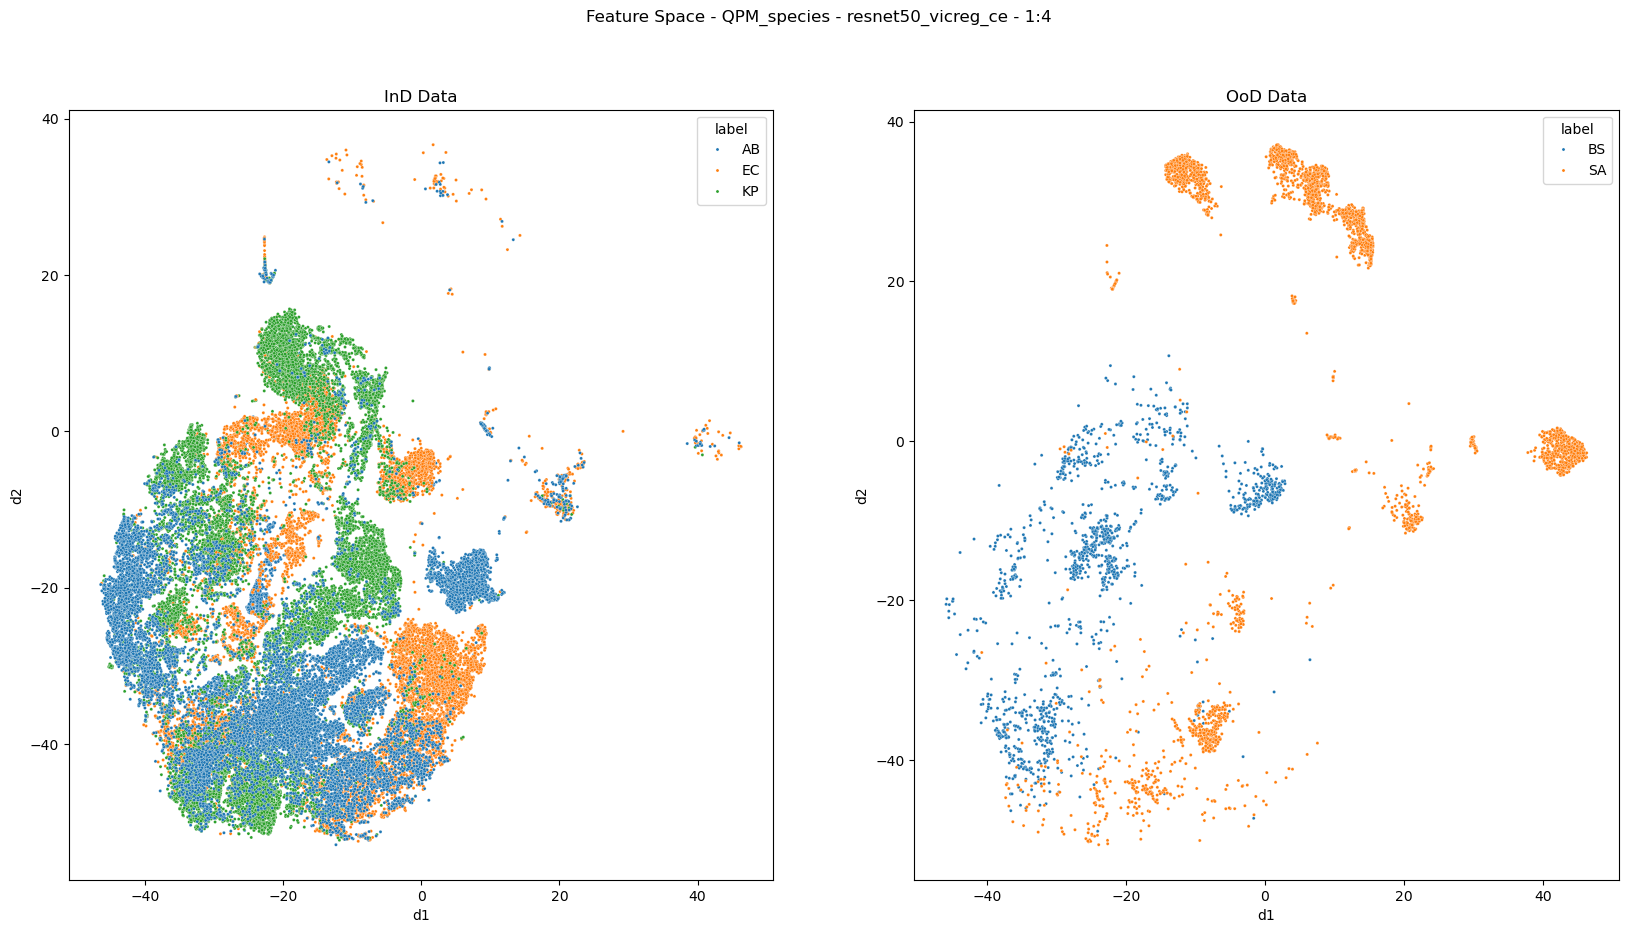

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

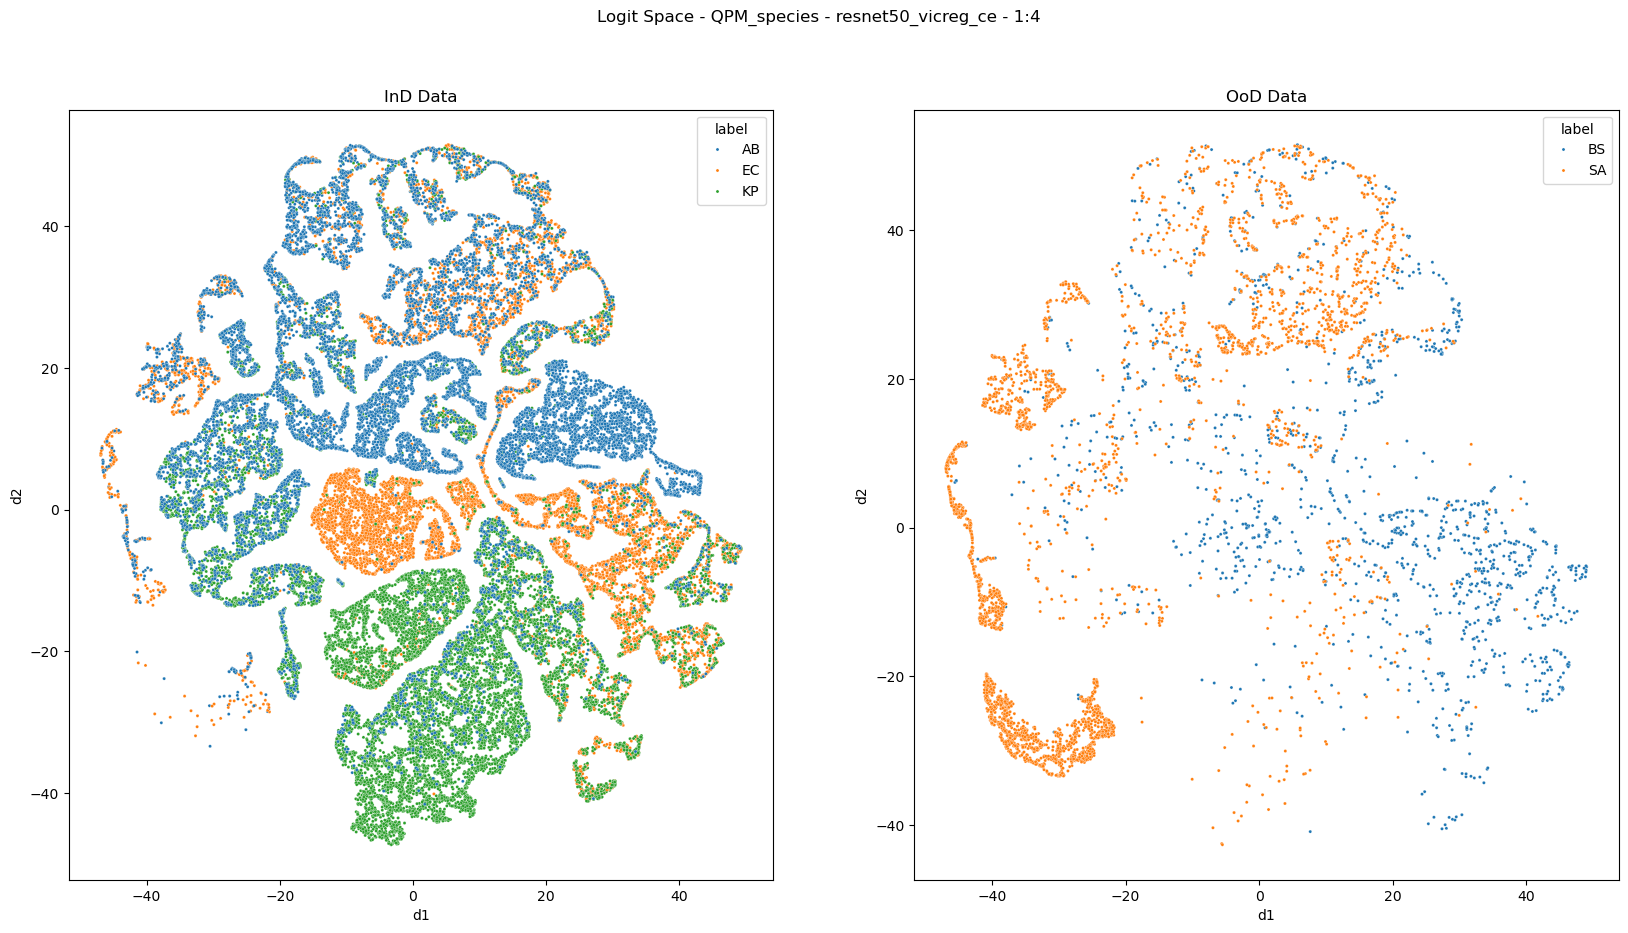

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:54<02:43, 54.38s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [01:48<01:48, 54.36s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [02:43<00:54, 54.50s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.78s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.65s/it]

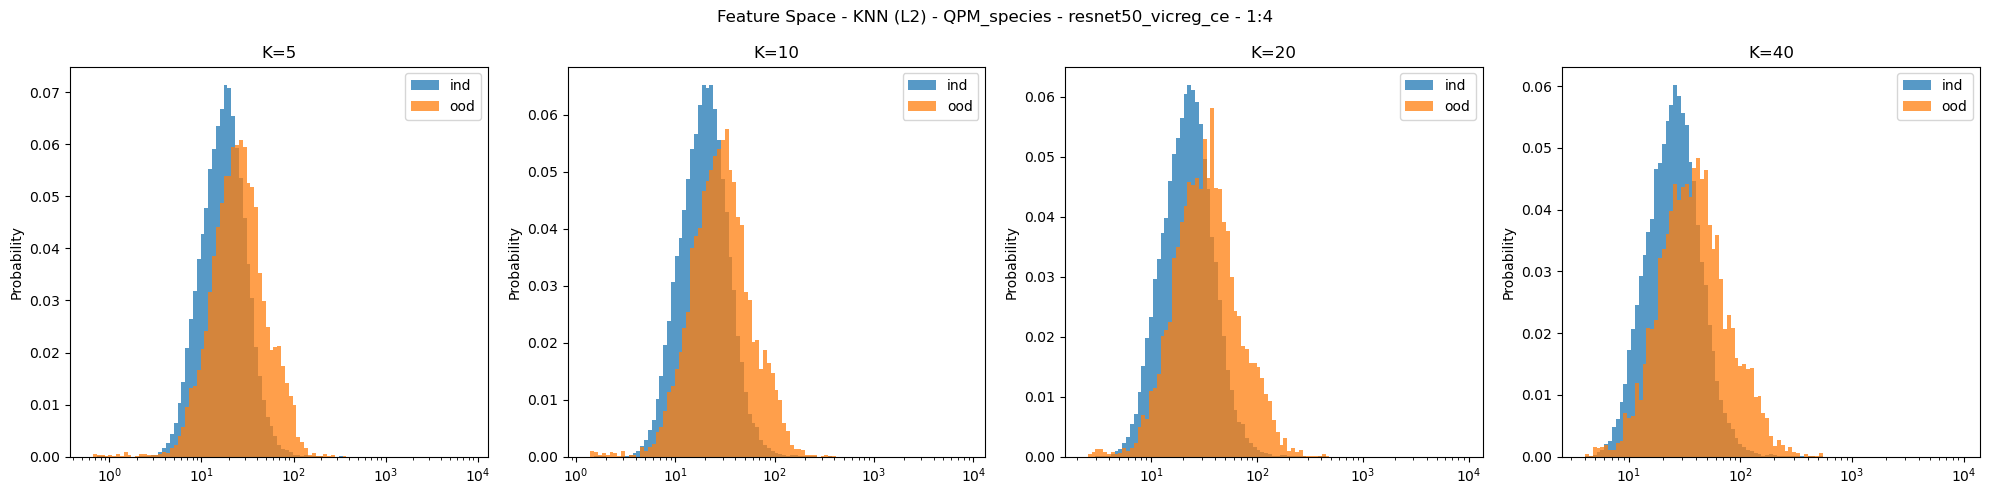

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:54<02:43, 54.42s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [01:48<01:48, 54.34s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [02:43<00:54, 54.44s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.62s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.54s/it]

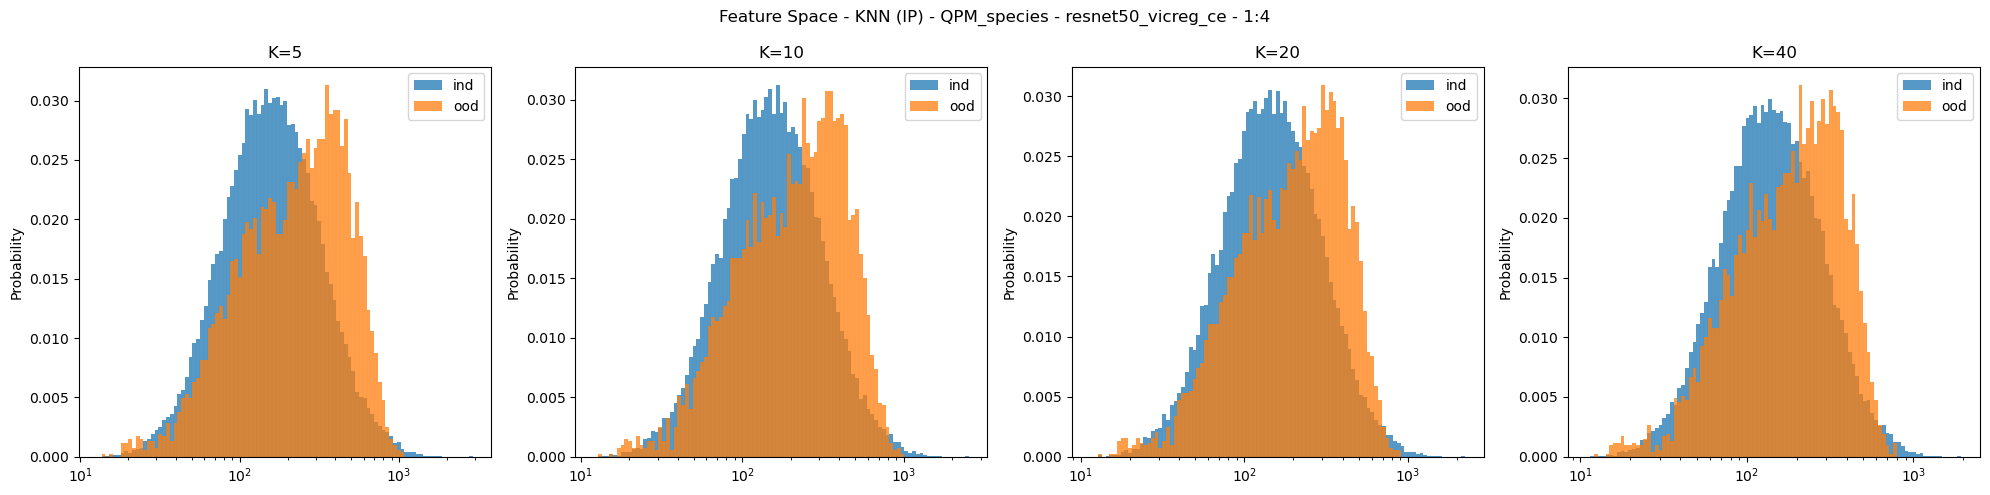

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:02<00:06,  2.06s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [00:04<00:04,  2.10s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [00:06<00:02,  2.18s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.44s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.33s/it]

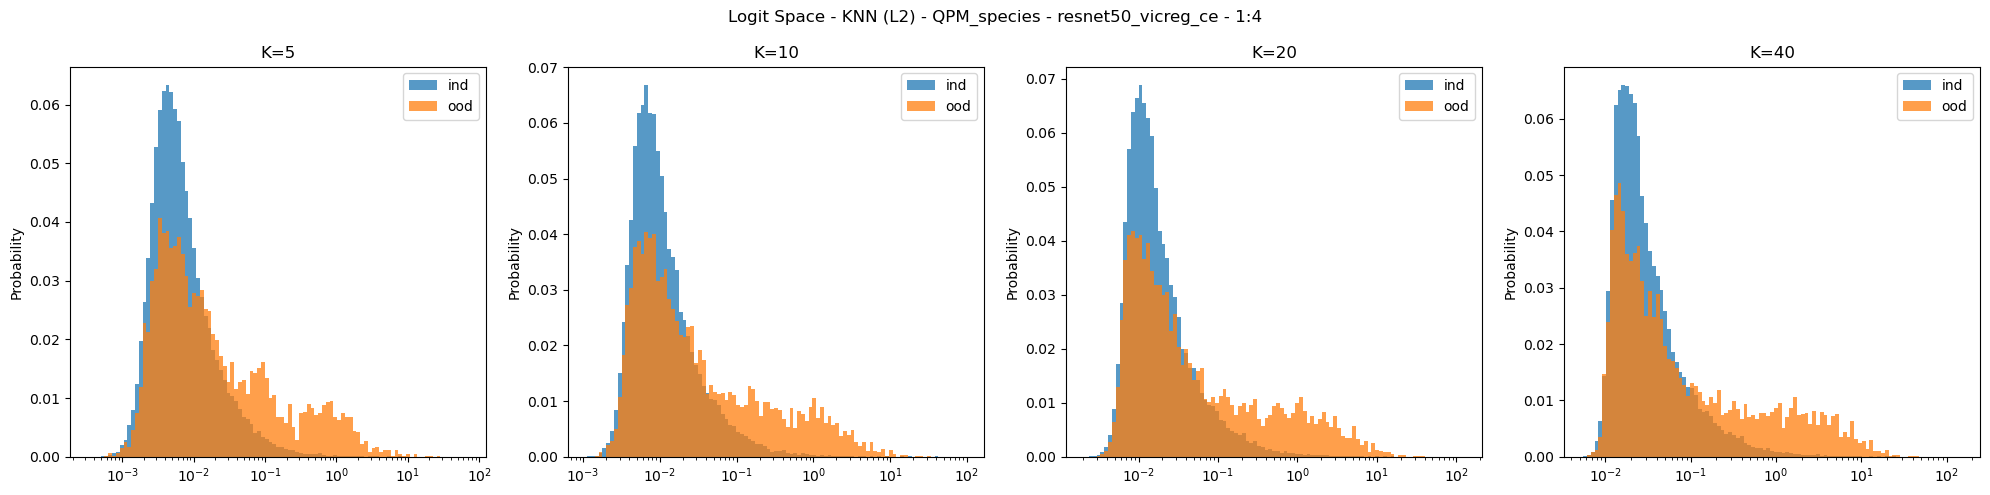

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:01<00:05,  1.78s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [00:03<00:03,  1.82s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [00:05<00:01,  1.91s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.10s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]

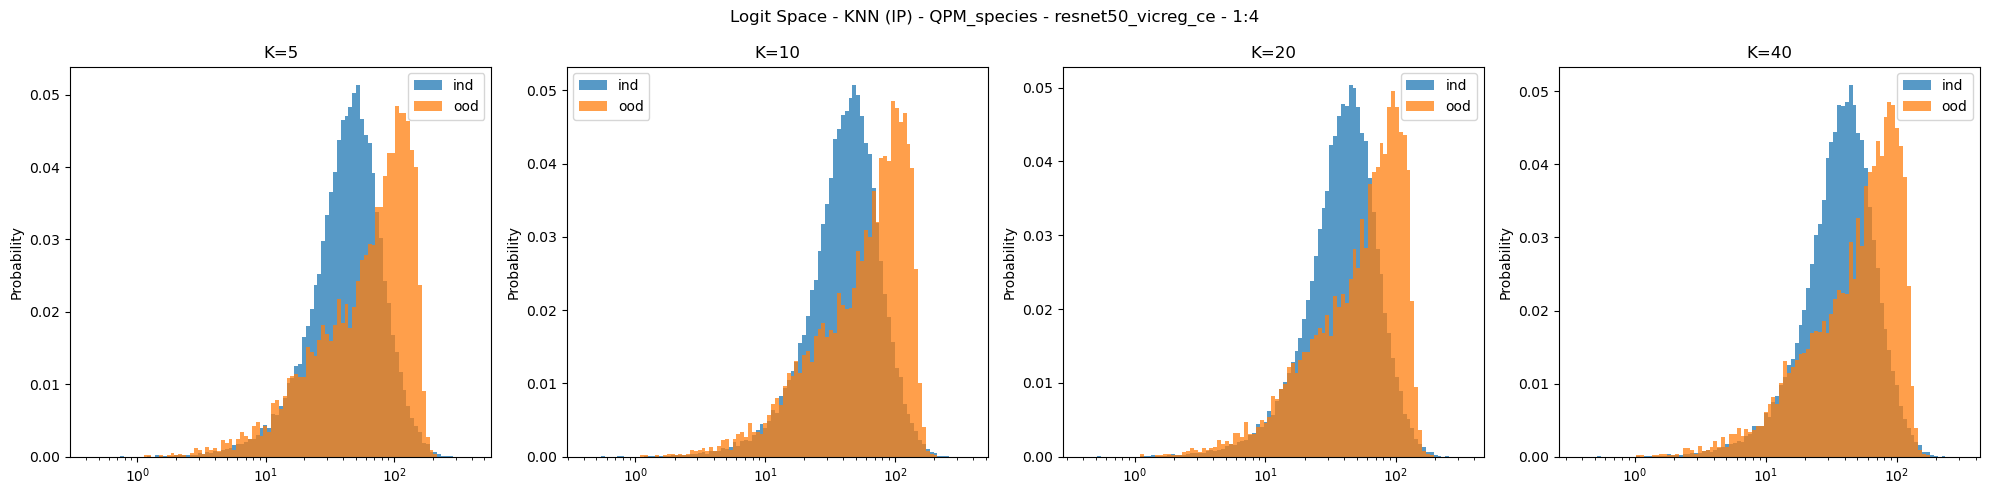

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

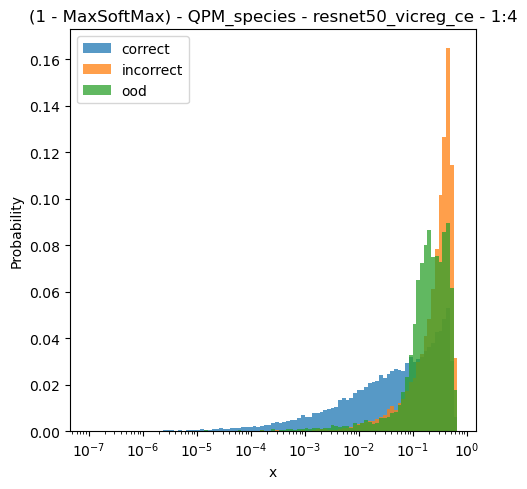

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()